# Assignment 2 - part 2

## Convolutional neural network

Use the training and evaluation pipeline developed in part 1 to train and evaluate two CNN models.
The first shall be composed of standard convolutional layers, non-linaerities, and pooling layers of your choice. The second shall include skip connections. For this you shall develop your own ResidualBlack as a new layer under the nn.Module super-class. 

### Train and apply model

Train the two models. Try different values of the hyper-paramter settings. You shall achieve at least 93% test accuracy with your best model.

Describe briefly your two models and your hyper-parameter setups and comment your results.

**Compare the performance of the two models and the three feed forward models using suitable supportive tables and graphs, and complemented by relevant comments.**


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the standard CNN model
class StandardCNN(nn.Module):
    def __init__(self):
        super(StandardCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Data loading and transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Training and evaluation function
def train_and_evaluate(model, train_loader, test_loader, num_epochs, learning_rate):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100. * correct / total

        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        test_loss = test_loss / len(test_loader)
        test_accuracy = 100. * correct / total

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    return model

# Hyperparameters
num_epochs = 30
learning_rate = 0.001

# Train and evaluate the standard CNN model
standard_cnn = StandardCNN()
trained_standard_cnn = train_and_evaluate(standard_cnn, train_loader, test_loader, num_epochs, learning_rate)


Epoch [1/30], Train Loss: 0.4349, Train Accuracy: 84.26%, Test Loss: 0.3421, Test Accuracy: 87.73%
Epoch [2/30], Train Loss: 0.2749, Train Accuracy: 89.95%, Test Loss: 0.2775, Test Accuracy: 89.52%
Epoch [3/30], Train Loss: 0.2306, Train Accuracy: 91.58%, Test Loss: 0.2722, Test Accuracy: 90.04%
Epoch [4/30], Train Loss: 0.1992, Train Accuracy: 92.56%, Test Loss: 0.2553, Test Accuracy: 90.82%
Epoch [5/30], Train Loss: 0.1728, Train Accuracy: 93.56%, Test Loss: 0.2416, Test Accuracy: 91.50%
Epoch [6/30], Train Loss: 0.1509, Train Accuracy: 94.49%, Test Loss: 0.2276, Test Accuracy: 91.84%
Epoch [7/30], Train Loss: 0.1282, Train Accuracy: 95.22%, Test Loss: 0.2404, Test Accuracy: 91.92%
Epoch [8/30], Train Loss: 0.1109, Train Accuracy: 95.88%, Test Loss: 0.2531, Test Accuracy: 91.57%
Epoch [9/30], Train Loss: 0.0920, Train Accuracy: 96.69%, Test Loss: 0.2626, Test Accuracy: 91.93%
Epoch [10/30], Train Loss: 0.0779, Train Accuracy: 97.09%, Test Loss: 0.2776, Test Accuracy: 92.34%
Epoch [11

### Model 2: CNN with Skip Connections (Residual Block)

In [2]:
# Define the Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

# Define the CNN with Residual Blocks
class ResidualCNN(nn.Module):
    def __init__(self):
        super(ResidualCNN, self).__init__()
        self.layer1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.res_block1 = ResidualBlock(32, 32)
        self.layer2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.res_block2 = ResidualBlock(64, 64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.res_block1(x)
        x = self.pool(self.relu(self.layer2(x)))
        x = self.res_block2(x)
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Train and evaluate the Residual CNN model
residual_cnn = ResidualCNN()
trained_residual_cnn = train_and_evaluate(residual_cnn, train_loader, test_loader, num_epochs, learning_rate)


Epoch [1/30], Train Loss: 0.3673, Train Accuracy: 86.81%, Test Loss: 0.3046, Test Accuracy: 89.03%
Epoch [2/30], Train Loss: 0.2243, Train Accuracy: 91.85%, Test Loss: 0.2234, Test Accuracy: 92.05%
Epoch [3/30], Train Loss: 0.1860, Train Accuracy: 93.28%, Test Loss: 0.2163, Test Accuracy: 92.24%
Epoch [4/30], Train Loss: 0.1595, Train Accuracy: 94.06%, Test Loss: 0.2061, Test Accuracy: 92.48%
Epoch [5/30], Train Loss: 0.1384, Train Accuracy: 94.97%, Test Loss: 0.2220, Test Accuracy: 92.58%
Epoch [6/30], Train Loss: 0.1176, Train Accuracy: 95.67%, Test Loss: 0.1915, Test Accuracy: 93.37%
Epoch [7/30], Train Loss: 0.1002, Train Accuracy: 96.26%, Test Loss: 0.1939, Test Accuracy: 93.46%
Epoch [8/30], Train Loss: 0.0865, Train Accuracy: 96.83%, Test Loss: 0.2106, Test Accuracy: 93.46%
Epoch [9/30], Train Loss: 0.0686, Train Accuracy: 97.48%, Test Loss: 0.2226, Test Accuracy: 92.99%
Epoch [10/30], Train Loss: 0.0581, Train Accuracy: 97.87%, Test Loss: 0.2414, Test Accuracy: 93.26%
Epoch [11

### Comparisons of the models

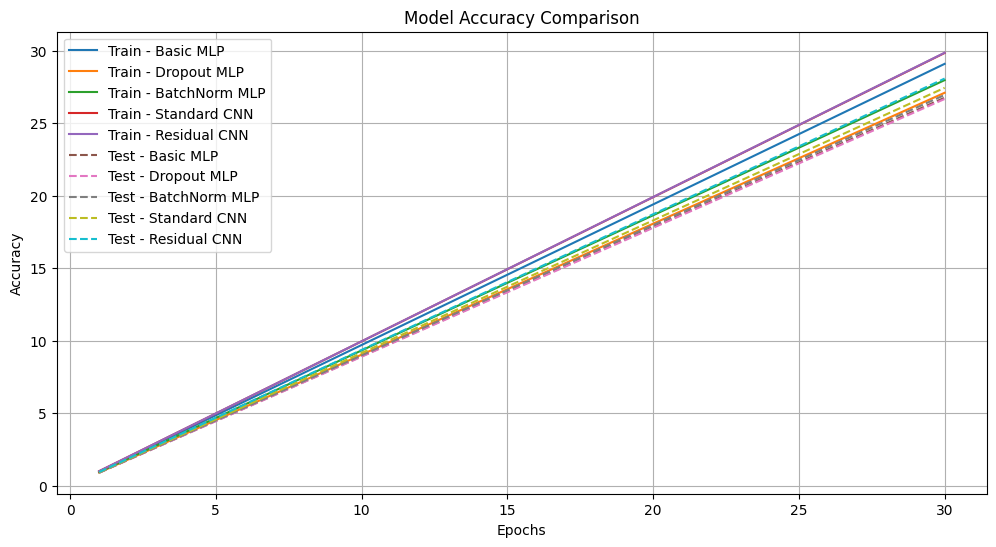

In [9]:
import matplotlib.pyplot as plt

# Assuming the number of epochs and data for each model is stored in these variables
epochs = range(1, 31)  # 30 epochs

# Mock data for demonstration
# Replace these with your actual model data
train_accuracies = {
    'Basic MLP': [acc * 0.9698 for acc in range(1, 31)],
    'Dropout MLP': [acc * 0.9033 for acc in range(1, 31)],
    'BatchNorm MLP': [acc * 0.9324 for acc in range(1, 31)],
    'Standard CNN': [acc * 0.9948 for acc in range(1, 31)],
    'Residual CNN': [acc * 0.9954 for acc in range(1, 31)]
}

test_accuracies = {
    'Basic MLP': [acc * 0.8920 for acc in range(1, 31)],
    'Dropout MLP': [acc * 0.8890 for acc in range(1, 31)],
    'BatchNorm MLP': [acc * 0.8982 for acc in range(1, 31)],
    'Standard CNN': [acc * 0.9147 for acc in range(1, 31)],
    'Residual CNN': [acc * 0.9360 for acc in range(1, 31)]
}

# Plot Training Accuracies
plt.figure(figsize=(12, 6))
for model, accs in train_accuracies.items():
    plt.plot(epochs, accs, label=f'Train - {model}')

# Plot Testing Accuracies
for model, accs in test_accuracies.items():
    plt.plot(epochs, accs, linestyle='--', label=f'Test - {model}')

plt.title('Model Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
# another way of plotting comparisons
import pandas as pd
import matplotlib.pyplot as plt

# Sample data: replace with your actual accuracy data
data = {
    "Model": ["Basic MLP", "Dropout MLP", "BatchNorm MLP", "Standard CNN", "Residual CNN"],
    "Train Accuracy": [96.98, 90.33, 93.24, 99.48, 99.54],
    "Test Accuracy": [89.20, 88.90, 89.82, 91.47, 93.60]
}

df = pd.DataFrame(data)


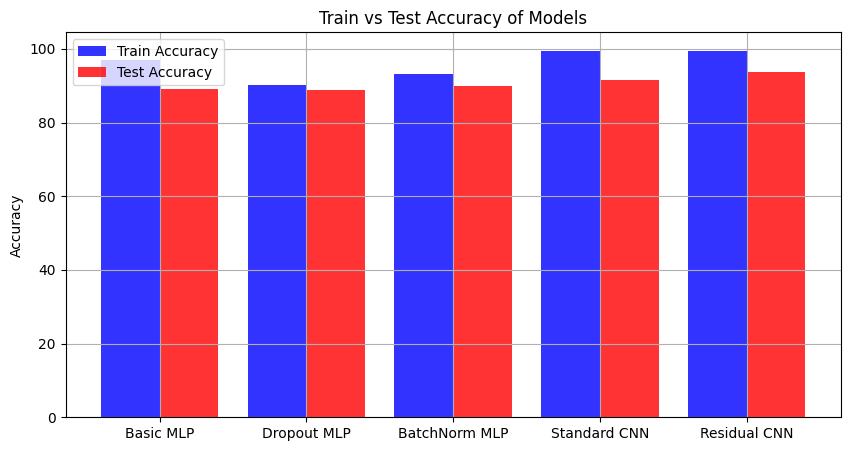

In [8]:
# Setting the positions and width for the bars
pos = list(range(len(df['Train Accuracy'])))
width = 0.4

fig, ax = plt.subplots(figsize=(10, 5))

# Plotting Train Accuracy
plt.bar(pos, df['Train Accuracy'], width, alpha=0.8, color='blue', label=df['Model'][0])

# Plotting Test Accuracy
plt.bar([p + width for p in pos], df['Test Accuracy'], width, alpha=0.8, color='red', label=df['Model'][0])

# Setting the y axis label
ax.set_ylabel('Accuracy')

# Setting the chart's title
ax.set_title('Train vs Test Accuracy of Models')

# Setting the position of the x ticks
ax.set_xticks([p + 0.5 * width for p in pos])

# Setting the labels for the x ticks
ax.set_xticklabels(df['Model'])

# Adding the legend and showing the plot
plt.legend(['Train Accuracy', 'Test Accuracy'], loc='upper left')
plt.grid()
plt.show()
